In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim as SSIM
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 48, 48, 3), dtype="float64")
    for i in range(number):
        I = cv2.imread(path + "{:04}_{}.jpeg".format(i+1, train_type))
        result[i, :, :, :] = I
    return result/result.max()

In [3]:
'''load images, parse test/validation set'''

dataNum = 4000
dataPath = "testcase_pro/"
x1 = load_imgs(dataPath, dataNum, 1)
x2 = load_imgs(dataPath, dataNum, 2)
y = load_imgs(dataPath, dataNum, 0)
y = y[:, 8:-8, 8:-8, :]
mask1 = load_imgs(dataPath, dataNum, 4)
mask1 = mask1[:, 8:-8, 8:-8, :1]
mask2 = 1-mask1
mask = np.concatenate((mask1, mask2), axis = 3)

x_train1, x_test1, x_train2, x_test2, y_train, y_test, mask_train, mask_test = train_test_split(
    x1, x2, y, mask, test_size=0.25)

In [4]:
# input size: Nonex48x48x3
# output size: Nonex36x36x16
def pre_convblock(x):
    y = layers.Conv2D(filters = 16, kernel_size = (5, 5), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 16, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    return y

In [5]:
# tensor format: [batch, in_height, in_width, in_channels]
# input size: Nonex36x36x32 (cat: 16+16)
# output size: Nonex32x32x2
# softmax is applied along the channel axis.
def post_convblock(x):
    y = layers.Conv2D(filters = 64, kernel_size=(3, 3), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 32, kernel_size=(1, 1), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid", activation = 'tanh')(y)
#    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid")(y)

    y = layers.Softmax(axis = -1)(y)
    return y

In [6]:
# input: out-of-focus image block A & block B, which denote the same area of the whole picture.
#        each: 48x48x3
# output: 
def fusionnet(inTensor1, inTensor2):
    out1 = pre_convblock(inTensor1)
    out2 = pre_convblock(inTensor2)

    x = layers.Concatenate(axis = -1)([out1, out2])
    y = post_convblock(x)
    
    return y

In [7]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
    # crop the input images to the same size as network output.
    inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
    inCrop2 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor2)
    # y1, y2 = tf.split(y, [1, 1], axis = 3)
    # extend y1&y2 dimension to 3, consistant to color channels
    y1 = y[:, :, :, :1]
    y2 = y[:, :, :, 1:]
    y1 = K.tile(y1, [1, 1, 1, 3])
    y2 = K.tile(y2, [1, 1, 1, 3])
    y1 = layers.Multiply()([inCrop1, y1])
    y2 = layers.Multiply()([inCrop2, y2])
    y = layers.Add()([y1, y2])
    return y

In [8]:
img1 = layers.Input(shape=(48, 48, 3))
img2 = layers.Input(shape=(48, 48, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer
pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [9]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
# generator.summary()

In [10]:
'''tv_loss: designed constraint on mask. WORKS NOT WELL.'''

# def tv_loss(y_true, y_pred):
#     #mapping = tf.cast(y_pred > 0.5, y_pred.dtype)
#     #loss = tf.reduce_mean(tf.image.total_variation(mapping))

# #     mapping = 0.25 - tf.square(y_pred-0.5) # 0.25-(x-0.5)^2
#     sigma = 0.2
#     mu = 0.5
#     mapping = tf.exp(-0.5*tf.square((y_pred - mu)/sigma))
#     loss = tf.reduce_mean(mapping)
#     return loss

'tv_loss: designed constraint on mask. WORKS NOT WELL.'

In [11]:
'''train on generator using MSE of pred & mask.'''

# lambda_tv = 1
# generator.compile(loss=[losses.mean_squared_error, 'mse'], loss_weights=[0, lambda_tv], optimizer= _optimizer)
# generator.fit([x_train1, x_train2], [y_train, mask_train], batch_size=64, epochs=5)



# prediction, a = generator.predict([x1, x2])
# get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#                                   [generator.layers[-2].output])

# layer_output = np.array(get_layer_output([x1, x2])[0])

# imgIdx = 6
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x1[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x2[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow(layer_output[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 5)
# plt.imshow(prediction[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y[imgIdx, :, :, :])
# plt.show()
# fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))

'train on generator using MSE of pred & mask.'

In [12]:
def dis_block(x, _filters, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = (5, 5), strides = _strides, 
                      padding='same')(x)
    y = layers.LeakyReLU(alpha=0.2)(y)
    if bn:
        y = layers.BatchNormalization(momentum=0.8)(y)
    return y

In [13]:
def disnet(x):
    y = dis_block(x, 32, (2, 2), bn = False)
    y = dis_block(y, 64, (1, 1))
    y = dis_block(y, 64, (2, 2))
    y = dis_block(y, 128, (1, 1))
    y = dis_block(y, 128, (2, 2))
#     y = dis_block(y, 256, (2, 2))
#     y = dis_block(y, 256, (2, 2))
    y = layers.Flatten()(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    return y

In [14]:
dis_input = layers.Input(shape=(32, 32, 3))
dis_output = disnet(dis_input)
discriminator = Model(inputs = dis_input, outputs = dis_output)
# discriminator.summary()

In [15]:
# discriminator.compile(loss='mse', optimizer= _optimizer)
# y_fake = generator.predict([x_train1, x_train2])
# dis_input = np.concatenate((y_fake, y_train), axis = 0)
# label = np.append(np.zeros((y_fake.shape[0], )), np.ones((y_train.shape[0], )))

# for e in range(20):
#     discriminator.fit(dis_input, label)

# label = discriminator.predict(x_test1[:, 8:-8, 8:-8, :])
# print(np.sum(label < 0.5))
# print(label)

In [16]:
def gannet(x):
    img1, img2 = x
    pred, intermed = generator([img1, img2])
    prob = discriminator(pred)
    discriminator.trainable = False
    return (prob, intermed)

In [17]:
prob, intermed = gannet([img1, img2])
gan = Model(inputs = [img1, img2], outputs= [prob, intermed])
# gan.summary()

In [18]:
# prediction = gan.predict([x1, x2])
# mask = prediction[1]
# plt.imshow(mask[6, :, :, 0])
# mask_tensor = tf.convert_to_tensor(mask)
# tv = tf.image.total_variation(mask_tensor)
# sess = tf.Session()
# loss = tv.eval(session=sess)

# print(loss[:10]/32/32/2)

In [19]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

  1%|▏         | 1/80 [00:05<06:49,  5.18s/it]

0.8083962886528983


  2%|▎         | 2/80 [00:09<06:18,  4.86s/it]

0.8123231148075826


  4%|▍         | 3/80 [00:13<06:07,  4.77s/it]

0.8152881527379305


  5%|▌         | 4/80 [00:18<06:02,  4.77s/it]

0.8170095106636679


  6%|▋         | 5/80 [00:24<06:14,  4.99s/it]

0.8210851350203962


  8%|▊         | 6/80 [00:30<06:33,  5.32s/it]

0.8244597838814949


  9%|▉         | 7/80 [00:36<06:55,  5.69s/it]

0.8280828201881016


 10%|█         | 8/80 [00:44<07:27,  6.21s/it]

0.8306137769758051


 11%|█▏        | 9/80 [00:52<07:56,  6.70s/it]

0.8297369843335572


 12%|█▎        | 10/80 [01:00<08:33,  7.34s/it]

0.8319960761547728


 14%|█▍        | 11/80 [01:10<09:07,  7.94s/it]

0.8330398056738696


 15%|█▌        | 12/80 [01:20<09:51,  8.70s/it]

0.8249636853658654


 16%|█▋        | 13/80 [01:31<10:28,  9.38s/it]

0.8380500350769179


 18%|█▊        | 14/80 [01:43<11:07, 10.12s/it]

0.8242355321096492


 19%|█▉        | 15/80 [01:56<11:56, 11.02s/it]

0.8396357794122923


 20%|██        | 16/80 [02:10<12:34, 11.79s/it]

0.8464084156293711


 21%|██▏       | 17/80 [02:24<13:16, 12.64s/it]

0.8289542722163871


 22%|██▎       | 18/80 [02:40<13:59, 13.54s/it]

0.8455426362051611


 24%|██▍       | 19/80 [02:57<14:52, 14.64s/it]

0.8288432682966382


 25%|██▌       | 20/80 [03:15<15:35, 15.59s/it]

0.845191683729761


 26%|██▋       | 21/80 [03:34<16:16, 16.56s/it]

0.834376352368717


 28%|██▊       | 22/80 [03:54<16:58, 17.57s/it]

0.8464892063447899


 29%|██▉       | 23/80 [04:15<17:40, 18.61s/it]

0.8360619837617499


 30%|███       | 24/80 [04:37<18:26, 19.76s/it]

0.8556607992353085


 31%|███▏      | 25/80 [05:01<19:19, 21.08s/it]

0.8228757517674922


 32%|███▎      | 26/80 [05:26<19:59, 22.21s/it]

0.8566924121972933


 34%|███▍      | 27/80 [05:52<20:36, 23.33s/it]

0.8284273538742267


 35%|███▌      | 28/80 [06:19<21:15, 24.52s/it]

0.855669166101258


 36%|███▋      | 29/80 [06:48<21:52, 25.74s/it]

0.8388279641378565


 38%|███▊      | 30/80 [07:18<22:28, 26.98s/it]

0.8466428570534825


 39%|███▉      | 31/80 [07:50<23:13, 28.44s/it]

0.8437446141936588


 40%|████      | 32/80 [08:22<23:42, 29.63s/it]

0.8435908467883144


 41%|████▏     | 33/80 [08:56<24:08, 30.83s/it]

0.8475725853588024


 42%|████▎     | 34/80 [09:31<24:31, 32.00s/it]

0.8404366996833964


 44%|████▍     | 35/80 [10:07<24:54, 33.22s/it]

0.8494652706086159


 45%|████▌     | 36/80 [10:44<25:19, 34.54s/it]

0.8390343818807239


 46%|████▋     | 37/80 [11:23<25:43, 35.89s/it]

0.8533694858714632


 48%|████▊     | 38/80 [12:05<26:15, 37.51s/it]

0.8767542145880768


 49%|████▉     | 39/80 [12:47<26:37, 38.96s/it]

0.7903155971839575


 50%|█████     | 40/80 [13:30<26:52, 40.31s/it]

0.8750047049337807


 51%|█████▏    | 41/80 [14:15<27:05, 41.67s/it]

0.7971289011150214


 52%|█████▎    | 42/80 [15:02<27:18, 43.11s/it]

0.8712557552731995


 54%|█████▍    | 43/80 [15:50<27:35, 44.73s/it]

0.8902565154736504


 55%|█████▌    | 44/80 [16:40<27:46, 46.28s/it]

0.8059104164229454
0.8844853052007142


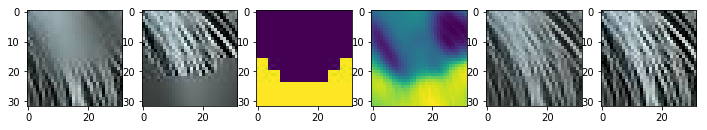

In [20]:
epoch = 80
batchSize = 64
tempSSIM = 0
losses = {"d":[], "g":[]}
for e in tqdm(range(epoch)):
    rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
    img_batch1 = x_train1[rand_idx, :, :, :]
    img_batch2 = x_train2[rand_idx, :, :, :]
    mask_batch = mask_train[rand_idx, :, :, :]
    y_batch = y_train[np.random.randint(0, y_train.shape[0], size = batchSize), :, :, :]
    img_fake = generator.predict([img_batch1, img_batch2])[0]
    img_valid = y_batch
    dis_input = np.concatenate((img_fake, img_valid), axis = 0)
    label = np.append(np.zeros((batchSize, )), np.ones((batchSize, )))
    
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=_optimizer)
    d_loss = discriminator.train_on_batch(dis_input, label)
    losses["d"].append(d_loss)
    
    gan_label = np.ones((batchSize,))
    discriminator.trainable = False
    gan.compile(loss = ['binary_crossentropy', 'mse'], loss_weights=[1, 99], optimizer=_optimizer)

    g_loss = gan.train_on_batch([img_batch1, img_batch2], [gan_label, mask_batch])
    losses["g"].append(g_loss[1])
    
#    if e % 5 == 4:
#         lambda_tv = max(lambda_tv/10, 1)
#        plot_loss(losses)

    imgIdx = 6
    prediction = generator.predict([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0]
    ssim = SSIM(y[imgIdx, :, :, :], prediction[0, :, :, :], data_range=prediction[0, :, :, :].max() - prediction[0, :, :, :].min(), multichannel=True)
    print(ssim)
    if ssim > tempSSIM:
        tempSSIM = ssim
    if ssim > 0.88 and ssim < tempSSIM:


        get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                          [generator.layers[-2].output])

        layer_output = np.array(get_layer_output([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0])

        fig=plt.figure(figsize=(12, 12))
        columns = 6
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(x1[imgIdx, 8:-8, 8:-8, :])
        fig.add_subplot(rows, columns, 2)
        plt.imshow(x2[imgIdx, 8:-8, 8:-8, :])
        fig.add_subplot(rows, columns, 3)
        plt.imshow(mask[imgIdx, :, :, 0])
        fig.add_subplot(rows, columns, 4)
        plt.imshow(layer_output[0, :, :, 0])
        fig.add_subplot(rows, columns, 5)
        plt.imshow(prediction[0, :, :, :])
        fig.add_subplot(rows, columns, 6)
        plt.imshow(y[imgIdx, :, :, :])
        plt.show()
        fig.savefig(dataPath+"results/struc_ep{}_{}.png".format(e,98))
        break

In [21]:
prediction = generator.predict([x_test1, x_test2])
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_test1, x_test2])[0])
ssim = SSIM(y_test[imgIdx, :, :, :], prediction[0, :, :, :], data_range=prediction[0, :, :, :].max() - prediction[0, :, :, :].min(), multichannel=True)
print(ssim)

imgIdx = 6
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x_test1[imgIdx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 2)
plt.imshow(x_test2[imgIdx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 3)
plt.imshow(layer_output[imgIdx, :, :, 0])
fig.add_subplot(rows, columns, 4)
plt.imshow(prediction[0][imgIdx, :, :, :])
fig.add_subplot(rows, columns, 5)
plt.imshow(y_test[imgIdx, :, :, :])
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
generator.save('generator.h5')